# Fixation, Saccade and Blink Analysis Cyprus Data

This code was developed and written by Jasmin L. Walter

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Import

In [2]:
import copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from os.path import exists

import matplotlib.pyplot as plt  # mother of plots focr Python

# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count

import scipy.signal

In [3]:
# warnings.simplefilter(action="ignore", category=FutureWarning)

# raw and processed data paths
# PATH_RAW = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/27.07.23/data"
# PATH_PROC = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/Events"
# PATH_FOREYE = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/ET_Output_MAD-sacc"
# PATH_TRG = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/TriggerFiles_fEEG"


# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

Total CPU threads: 8


In [8]:

savepath = "F:/Cyprus_project_overview/data/analysis/eyeTracking/fixation_analysis"

datapath = "F:/Cyprus_project_overview/store_cyprus_project/eyeTrackingData"



# Getting the Folder without hidden files in ascending order 
data_folders = sorted([f for f in os.listdir(datapath) if not f.startswith('.')], key=str.lower)
# PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

# savepath = r'F:\WestbrookProject\SpaRe_Data\pre-processing_2023\step1_preparation\'
# os.chdir(r'F:\WestbrookProject\SpaRe_Data\pre-processed_csv\')

In [9]:
print(data_folders)

['Expl_1_ET_1_2023-09-05_11-56-16_ET', 'Expl_1_ET_2_2023-09-05_12-34-24_ET', 'Expl_1_ET_3_2023-09-05_13-10-01_ET', 'Expl_2_ET_1_2023-09-06_10-36-37_ET', 'Expl_2_ET_2_2023-09-06_11-08-36_ET', 'Expl_2_ET_3_2023-09-06_11-39-21_ET', 'Expl_3_ET_1_2023-09-06_13-24-43_ET', 'Expl_3_ET_2_2023-09-06_13-57-57_ET', 'Expl_3_ET_3_2023-09-06_14-28-39_ET', 'Expl_4_ET_1_2023-09-06_18-31-33_ET', 'Expl_4_ET_2_2023-09-06_18-57-24_ET', 'Expl_5_ET_1_2023-09-07_18-17-19_ET', 'Expl_5_ET_2_2023-09-07_18-48-26_ET']


## Load data

In [86]:
def calculateSaccadeLenths(gazeData):
    
    sDurations = []

    index = gazeData.index.tolist()
    
    startIndex = 0
    firstSample = True
    
    for idx in index:

        if math.isnan(gaze.loc[idx,"fixation id"]):
                    
            # save timestamp of first sample
            if firstSample:
                startIndex = gaze.loc[idx,"timestamp [ns]"]
                firstSample = False
            
            # if it is the last saccade sample or the last sample of the data, save duration and set firstSample True again
            if not (idx == len(index)-1):
                
                if not math.isnan(gaze.loc[idx+1,"fixation id"]):

                    duration = (gaze.loc[idx,"timestamp [ns]"] - startIndex)/1000000
                    sDurations.append(duration)

                    firstSample = True
            else:
                duration = (gaze.loc[idx,"timestamp [ns]"] - startIndex)/1000000
                sDurations.append(duration)
                

    return  sDurations
    

In [96]:
gaze.head()

,section id,recording id,timestamp [ns],gaze x [px],gaze y [px],worn,fixation id,blink id,azimuth [deg],elevation [deg]
0,b8c56a46-b3dc-43c2-a30c-d287553c5ae3,d7a7b5da-afb3-4bc3-91ef-7e0ab1740c55,1694101708054762419,785.113,474.532,1.0,1.0,NaN,-2.342266,8.505025
1,b8c56a46-b3dc-43c2-a30c-d287553c5ae3,d7a7b5da-afb3-4bc3-91ef-7e0ab1740c55,1694101708061911419,784.056,474.263,1.0,1.0,NaN,-2.410717,8.522078
2,b8c56a46-b3dc-43c2-a30c-d287553c5ae3,d7a7b5da-afb3-4bc3-91ef-7e0ab1740c55,1694101708064511419,783.555,474.110,1.0,1.0,NaN,-2.443158,8.531807
3,b8c56a46-b3dc-43c2-a30c-d287553c5ae3,d7a7b5da-afb3-4bc3-91ef-7e0ab1740c55,1694101708070265419,783.126,474.026,1.0,1.0,NaN,-2.470937,8.537117
4,b8c56a46-b3dc-43c2-a30c-d287553c5ae3,d7a7b5da-afb3-4bc3-91ef-7e0ab1740c55,1694101708076525419,782.347,471.609,1.0,1.0,NaN,-2.521927,8.691931


In [99]:
def checkBlinks(gazeData):
    # Filter rows where "blink id" is not NaN
    blink_not_nan = gazeData[gazeData['blink id'].notna()]

    # Count how many of these rows have NaN in "fixation id"
    count_nan_fixation = blink_not_nan['fixation id'].isna().sum()

    # Count how many of these rows have non-NaN in "fixation id"
    count_not_nan_fixation = blink_not_nan['fixation id'].notna().sum()
    
    count_all =  len(blink_not_nan)
    
    return count_all, count_nan_fixation, count_not_nan_fixation
    

In [100]:
fixationDurations = []
saccadeDurations = []
blinkDurations = []

count_blink_rows = []
count_blink_isFix = []
count_blink_notFix = []

samplingRate = []

# files progress bar
folder_pbar = tqdm(
    iterable=data_folders,
    total=len(data_folders),
    desc="📂 ET files____________",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

    # loop necessary for displaying properly the progressbar with multiprocessing
    # source: https://stackoverflow.com/a/40133278

#             info_list = []

for folder in folder_pbar:

    print('process files of folder', folder)

    # read in data
    fixations = pd.read_csv(os.path.join(datapath, folder, "fixations.csv"))
    gaze = pd.read_csv(os.path.join(datapath, folder, "gaze.csv"))
    blinks = pd.read_csv(os.path.join(datapath, folder, "blinks.csv"))
    
    saccDurs = calculateSaccadeLenths(gaze)
    
    fixationDurations.extend(fixations["duration [ms]"])
    saccadeDurations.extend(saccDurs)
    blinkDurations.extend(blinks["duration [ms]"])
    
    count_all, count_nan_fixation, count_not_nan_fixation = checkBlinks(gaze)
    
    count_blink_rows.append(count_all)
    count_blink_isFix.append(count_not_nan_fixation)
    count_blink_notFix.append(count_nan_fixation)
    
    
    

print("done")

📄 0 of 13 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process files of folder Expl_1_ET_1_2023-09-05_11-56-16_ET
process files of folder Expl_1_ET_2_2023-09-05_12-34-24_ET
process files of folder Expl_1_ET_3_2023-09-05_13-10-01_ET
process files of folder Expl_2_ET_1_2023-09-06_10-36-37_ET
process files of folder Expl_2_ET_2_2023-09-06_11-08-36_ET
process files of folder Expl_2_ET_3_2023-09-06_11-39-21_ET
process files of folder Expl_3_ET_1_2023-09-06_13-24-43_ET
process files of folder Expl_3_ET_2_2023-09-06_13-57-57_ET
process files of folder Expl_3_ET_3_2023-09-06_14-28-39_ET
process files of folder Expl_4_ET_1_2023-09-06_18-31-33_ET
process files of folder Expl_4_ET_2_2023-09-06_18-57-24_ET
process files of folder Expl_5_ET_1_2023-09-07_18-17-19_ET
process files of folder Expl_5_ET_2_2023-09-07_18-48-26_ET
done


In [84]:
gaze.head()

,section id,recording id,timestamp [ns],gaze x [px],gaze y [px],worn,fixation id,blink id,azimuth [deg],elevation [deg]
0,a6790d70-f03c-402f-b672-095234a8c011,317671aa-12b7-44e9-a33f-35b0daff75b1,1693908602609369929,802.279,613.308,1.0,1.0,NaN,-1.224314,-0.406926
1,a6790d70-f03c-402f-b672-095234a8c011,317671aa-12b7-44e9-a33f-35b0daff75b1,1693908602616425929,802.253,613.099,1.0,1.0,NaN,-1.225967,-0.393477
2,a6790d70-f03c-402f-b672-095234a8c011,317671aa-12b7-44e9-a33f-35b0daff75b1,1693908602621898929,802.216,613.386,1.0,1.0,NaN,-1.228327,-0.411925
3,a6790d70-f03c-402f-b672-095234a8c011,317671aa-12b7-44e9-a33f-35b0daff75b1,1693908602625116929,801.885,613.651,1.0,1.0,NaN,-1.249580,-0.428931
4,a6790d70-f03c-402f-b672-095234a8c011,317671aa-12b7-44e9-a33f-35b0daff75b1,1693908602631194929,801.218,614.407,1.0,1.0,NaN,-1.292464,-0.477581


In [73]:
print(sumFix)
print(sumFix/1000)
print(sumFix/1000/60)

3361208
3361.208
56.020133333333334


In [88]:
print((sum(fixationDurations)/1000)/60)
print((sum(saccadeDurations)/1000)/60)
print((sum(blinkDurations)/1000)/60)
print(((sum(saccadeDurations) + sum(fixationDurations))/1000)/60)

230.62876666666668
39.37619275000005
25.424983333333333
270.00495941666674


In [106]:
gaze["diffs"] = gaze["timestamp [ns]"].diff()/1000000

In [107]:
print(np.nanmin(gaze["diffs"]))
print(np.nanmax(gaze["diffs"]))
print(np.nanmean(gaze["diffs"]))

0.169
65.515
5.0128427546209355


## Distribution of eye movements over data

In [101]:
blink_sum = sum(count_blink_rows) 
blink_isFix_sum =  sum(count_blink_isFix)
blink_notFix_sum =  sum(count_blink_notFix)

print(blink_sum)
print(blink_isFix_sum + blink_notFix_sum)
print(blink_isFix_sum )
print(blink_notFix_sum)


304601
304601
142140
162461


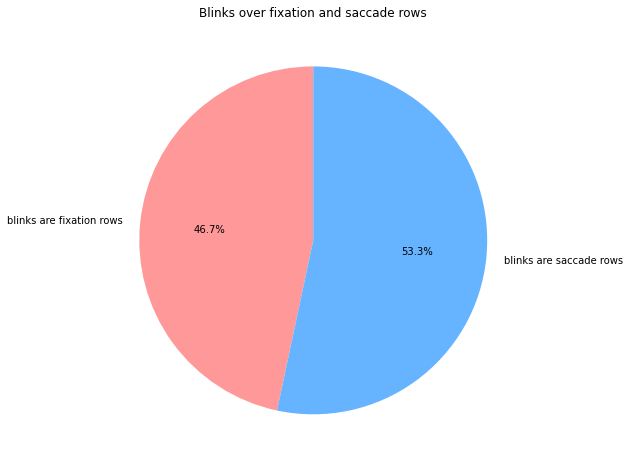

In [102]:
# Combine lengths into a list
lengths = [blink_isFix_sum, blink_notFix_sum]

# Define labels for the pie chart
labels = ['blinks are fixation rows', 'blinks are saccade rows']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Blinks over fixation and saccade rows')


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'pie_blinks.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


plt.show()

13837726
2362571.5650000027


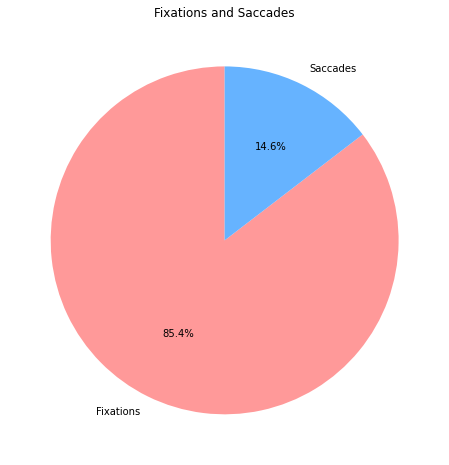

In [94]:
# Calculate the lengths
# gaze_sum = combined_gaze_data.sum()
# saccade_sum = combined_saccade_data.sum()
# noData_sum = combined_noData_data.sum()

gaze_sum = sum(fixationDurations)
saccade_sum = sum(saccadeDurations)


allD = gaze_sum + saccade_sum 
print(gaze_sum)
print(saccade_sum)

# Combine lengths into a list
lengths = [gaze_sum, saccade_sum]

# Define labels for the pie chart
labels = ['Fixations', 'Saccades']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Fixations and Saccades')


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'pie_fixation_saccade_sum.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


plt.show()

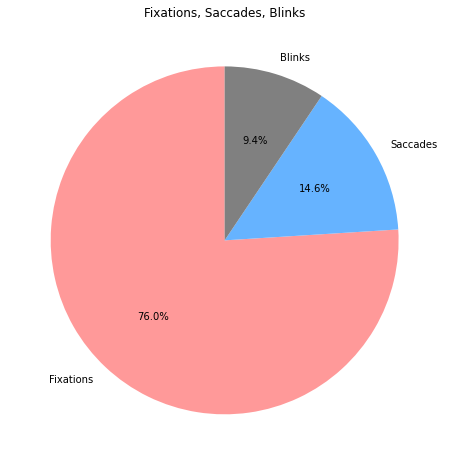

In [95]:
# Calculate the lengths
# gaze_sum = combined_gaze_data.sum()
# saccade_sum = combined_saccade_data.sum()
# noData_sum = combined_noData_data.sum()

gaze_sum = sum(fixationDurations) 
blink_sum =  sum(blinkDurations)
fixation_sum = gaze_sum - blink_sum
saccade_sum = sum(saccadeDurations)


allD = gaze_sum + saccade_sum 

# Combine lengths into a list
lengths = [fixation_sum, saccade_sum, blink_sum]

# Define labels for the pie chart
labels = ['Fixations', 'Saccades', 'Blinks']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','grey'])
plt.title('Fixations, Saccades, Blinks')


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'pie_fixation_saccade_blink_sum.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


plt.show()

## eye movement duration distribution

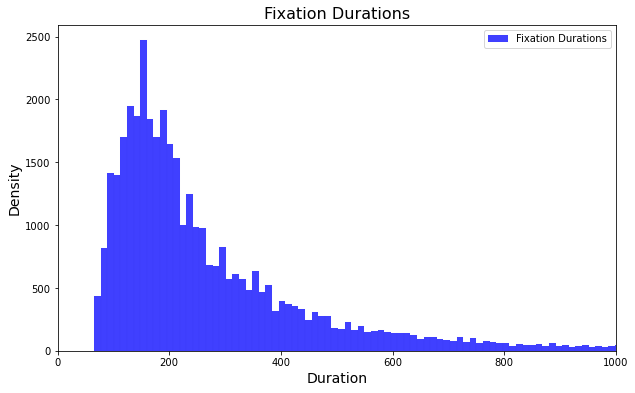

In [89]:
# binwidth = 1/90 

plt.figure(figsize=(10, 6))

# Plot KDE for gaze durations in blue
sns.histplot(fixationDurations, color='blue', label='Fixation Durations')

# # Plot KDE for saccade durations in red
# sns.histplot(combined_saccade_data, kde=True, color='red', label='Saccade Durations', binwidth=binwidth)

# plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Fixation Durations', fontsize=16)

plt.xlim(0, 1000)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'fixation_durations.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


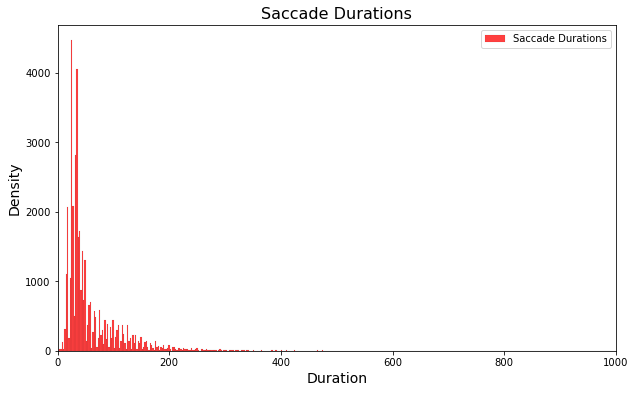

In [90]:
# binwidth = 1/90 

plt.figure(figsize=(10, 6))

# Plot KDE for gaze durations in blue
sns.histplot(saccadeDurations, color='red', label='Saccade Durations')

# # Plot KDE for saccade durations in red
# sns.histplot(combined_saccade_data, kde=True, color='red', label='Saccade Durations', binwidth=binwidth)

# plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Saccade Durations', fontsize=16)

plt.xlim(0, 1000)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'Saccade_durations.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


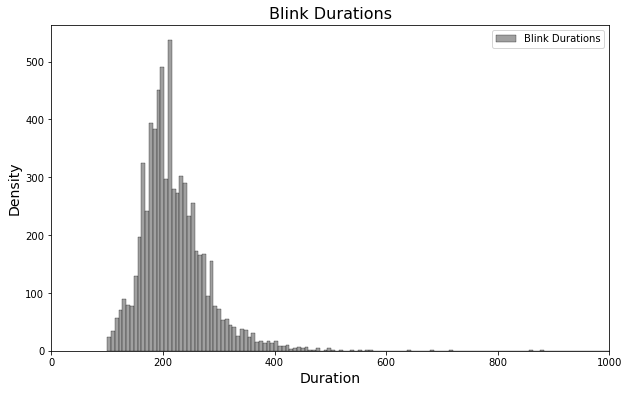

In [91]:
# binwidth = 1/90 

plt.figure(figsize=(10, 6))

# Plot KDE for gaze durations in blue
sns.histplot(blinkDurations, color='grey', label='Blink Durations')

# # Plot KDE for saccade durations in red
# sns.histplot(combined_saccade_data, kde=True, color='red', label='Saccade Durations', binwidth=binwidth)

# plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Blink Durations', fontsize=16)

plt.xlim(0, 1000)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'blink_durations.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


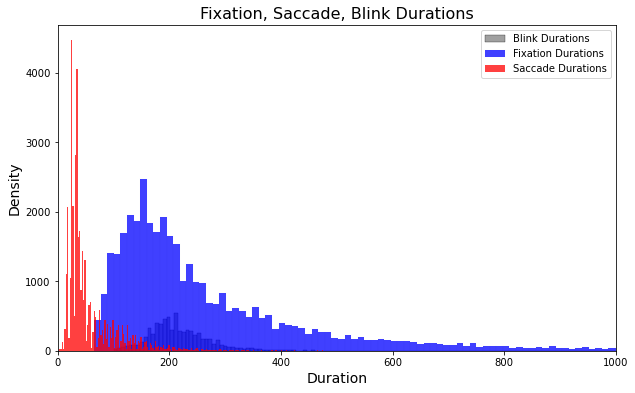

In [92]:
# binwidth = 1/90 

plt.figure(figsize=(10, 6))

sns.histplot(blinkDurations, color='grey', label='Blink Durations')

# Plot KDE for gaze durations in blue
sns.histplot(fixationDurations, color='blue', label='Fixation Durations')

# # Plot KDE for saccade durations in red
sns.histplot(saccadeDurations, color='red', label='Saccade Durations')

# plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Fixation, Saccade, Blink Durations', fontsize=16)

plt.xlim(0, 1000)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'fixation_saccade_blink_durations.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


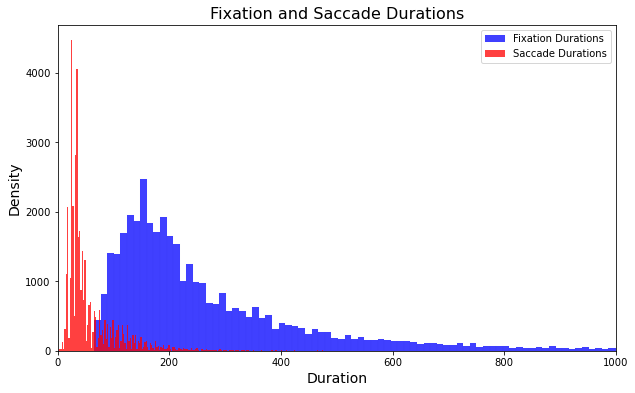

In [93]:
# binwidth = 1/90 

plt.figure(figsize=(10, 6))


# Plot KDE for gaze durations in blue
sns.histplot(fixationDurations, color='blue', label='Fixation Durations')

# # Plot KDE for saccade durations in red
sns.histplot(saccadeDurations, color='red', label='Saccade Durations')

# plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Fixation and Saccade Durations', fontsize=16)

plt.xlim(0, 1000)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(savepath, 'fixation_saccade_durations.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [113]:
print('--------eye movement statistics----------')
print('------------------------------------------')
print('-------------fixation stats----------')
print(min(fixationDurations)/1000)
print(max(fixationDurations)/1000)
print(np.mean(fixationDurations)/1000)
print(np.median(fixationDurations)/1000)

print('------------saccade stats----------')
print(min(saccadeDurations)/1000)
print(max(saccadeDurations)/1000)
print(np.mean(saccadeDurations)/1000)
print(np.median(saccadeDurations)/1000)

print('-------------blink stats----------')
print(min(blinkDurations)/1000)
print(max(blinkDurations)/1000)
print(np.mean(blinkDurations)/1000)
print(np.median(blinkDurations)/1000)


--------eye movement statistics----------
------------------------------------------
-------------fixation stats----------
0.065
73.603
0.3515682418699187
0.212
------------saccade stats----------
0.0
2.5065749999999998
0.060032310125778185
0.037498
-------------blink stats----------
0.1
1.271
0.2199075969439239
0.209
